In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

In [2]:
import seaborn as sns
sns.set()

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['FB','AMZN','GOOG','TWTR','TSLA']**

In [83]:
import yfinance as yf
stock_symbol = 'TSLA'
data = yf.download(tickers=stock_symbol,period='2y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
500,2022-04-21,1074.729980,1092.219971,996.419983,1008.780029,1008.780029,35138800
501,2022-04-22,1014.909973,1034.849976,994.000000,1005.049988,1005.049988,23181600
502,2022-04-25,978.969971,1008.619995,975.299988,998.020020,998.020020,22780400
503,2022-04-26,995.429993,1000.000000,875.000000,876.419983,876.419983,45377900
504,2022-04-27,898.580017,918.000000,877.359985,881.510010,881.510010,25585300


#### Visualizing the Real Stock Trend

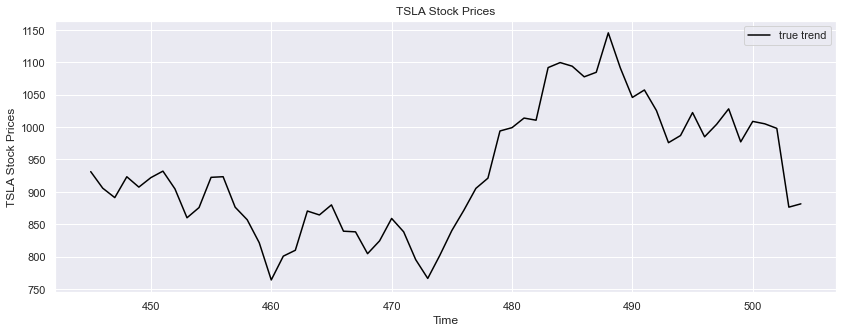

In [84]:
plt.figure(figsize=(14,5))
plt.plot(data['Close'][-60:],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [85]:
test_size = 60
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((505, 7), (445, 7), (60, 7))

#### Preparing the training data

In [86]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,159.128006,161.000000,151.337997,153.824005,76110000
1,158.033997,160.639999,156.632004,160.102005,81080000
2,171.037994,173.964005,152.699997,156.376007,142359500
3,151.000000,154.554001,136.608002,140.264008,162659000
4,140.199997,152.399994,139.600006,152.238007,96185500


In [87]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.01729833, 0.00788203, 0.01363394, 0.01244441, 0.31230054])

In [88]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,3])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape
# 385 rows
# 60 columns
# 5 dimentional data

((385, 60, 5), (385,))

#### Preparaing testing data

In [89]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((120, 5),
             Open         High          Low        Close    Volume
 385  1234.410034  1243.489990  1217.000000  1229.910034  25397400
 386  1228.000000  1239.869995  1208.000000  1222.089966  21628800
 387  1149.790039  1197.000000  1133.000000  1162.939941  33445700
 388  1173.599976  1174.500000  1011.520020  1023.500000  59105800
 389  1010.409973  1078.099976   987.309998  1067.949951  42802700)

In [90]:
df = scaler.transform(df)
df[0]

array([1.        , 1.        , 1.        , 1.        , 0.07345699])

In [91]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,3])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((60, 60, 5), (60,))

#### Defining the Scaling Label

In [92]:
# below is the scaling label, which will help inverse the transformation back to it's original values 
data_close = data.Close
data_close = data_close.values.reshape(-1, 1)
scaler_close = MinMaxScaler()
data_close_scaled = scaler_close.fit_transform(data_close)

In [93]:
y_test = y_test.reshape(-1,1)
y_test = scaler_close.inverse_transform(y_test)

### LSTM - Long Short-Term Memory

In [94]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [95]:
x_train.shape[1],x_train.shape[2]

(60, 5)

In [96]:
regression = Sequential()

# Input layer
regression.add(LSTM(units=40,activation='relu',return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
regression.add(Dropout(0.3))

# 3rd layer (Hidden)
regression.add(LSTM(units=80,activation='relu'))
regression.add(Dropout(0.4))

# Outer layer
regression.add(Dense(units=1))

regression.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 40)            7360      
                                                                 
 dropout_8 (Dropout)         (None, 60, 40)            0         
                                                                 
 lstm_9 (LSTM)               (None, 80)                38720     
                                                                 
 dropout_9 (Dropout)         (None, 80)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 81        
                                                                 
Total params: 46,161
Trainable params: 46,161
Non-trainable params: 0
_________________________________________________________________


In [97]:
regression.compile(optimizer='adam',loss='mean_squared_error',metrics='accuracy')

In [98]:
def forecast():
    regression.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = regression.predict(x_test)
    y_pred = y_pred.reshape(-1,1)
    y_pred = scaler_close.inverse_transform(y_pred)
    return y_pred

In [99]:
def first_forecast():
    history = regression.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = regression.predict(x_test)
    y_pred = y_pred.reshape(-1,1)
    y_pred = scaler_close.inverse_transform(y_pred)
    return history,y_pred

In [100]:
result_forecast = []
simulation = 1
print("Simulation 1")
history,first_result = first_forecast()
result_forecast.append(first_result)
for i in range(1,simulation):
    print("Simulation %d"%(i+1))
    result_forecast.append(forecast())


Simulation 1
Epoch 1/300
13/13 [==============================] - 3s 85ms/step - loss: 0.1373 - accuracy: 0.0000e+00
Epoch 2/300
13/13 [==============================] - 1s 80ms/step - loss: 0.0362 - accuracy: 0.0026
Epoch 3/300
13/13 [==============================] - 1s 82ms/step - loss: 0.0194 - accuracy: 0.0026
Epoch 4/300
13/13 [==============================] - 1s 81ms/step - loss: 0.0198 - accuracy: 0.0026
Epoch 5/300
13/13 [==============================] - 1s 40ms/step - loss: 0.0164 - accuracy: 0.0026
Epoch 6/300
13/13 [==============================] - 1s 41ms/step - loss: 0.0160 - accuracy: 0.0026
Epoch 7/300
13/13 [==============================] - 2s 158ms/step - loss: 0.0151 - accuracy: 0.0026
Epoch 8/300
13/13 [==============================] - 2s 162ms/step - loss: 0.0125 - accuracy: 0.0026
Epoch 9/300
13/13 [==============================] - 2s 164ms/step - loss: 0.0186 - accuracy: 0.0026
Epoch 10/300
13/13 [==============================] - 2s 163ms/step - loss: 0.01

#### Calculating the Accuracy using MAPE and RMSE

In [101]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    # mean Absolute Percentage Error - MAPE
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100
mean_accuracy = []
for i in range(simulation):
    mean_accuracy.append(calculate_accuracy(y_test, result_forecast[i]))

mean_accuracy

[95.79406561917182]

#### Visualization

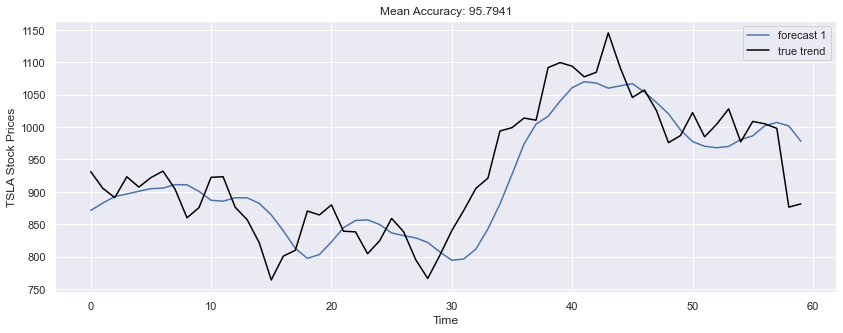

In [102]:
plt.figure(figsize=(14,5))
for i in range(simulation):
    plt.plot(result_forecast[i],label='forecast %d'%(i+1))
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mean_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()